In [2]:
import xgboost as xgb
import pandas as pd 
from sklearn.model_selection import  train_test_split, RandomizedSearchCV
from sklearn.metrics import auc, precision_recall_curve 
from imblearn.over_sampling import SMOTE 
import matplotlib.pyplot as plt 
from sklearn.metrics import make_scorer, precision_recall_curve, auc
from sklearn.metrics import average_precision_score
from scipy.stats import uniform, randint


In [5]:
credit_card = pd.read_csv('dataset/creditcard.csv')
credit_card.drop('V15', axis = 1 , inplace =True )

In [6]:
X = credit_card.drop("Class", axis = 1) # Features 
y = credit_card['Class']  # target variable 

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [10]:
smote = SMOTE(sampling_strategy={1:10000}, random_state=42)

In [11]:
X_sampled , y_sampled = smote.fit_resample(X_train, y_train )

In [15]:
X_sampled.shape , y_sampled.shape

((180583, 29), (180583,))

In [12]:
model = xgb.XGBClassifier()

In [13]:
model.fit(X_sampled, y_sampled)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [16]:
y_pred_proba = model.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
auprc = auc(recall, precision)

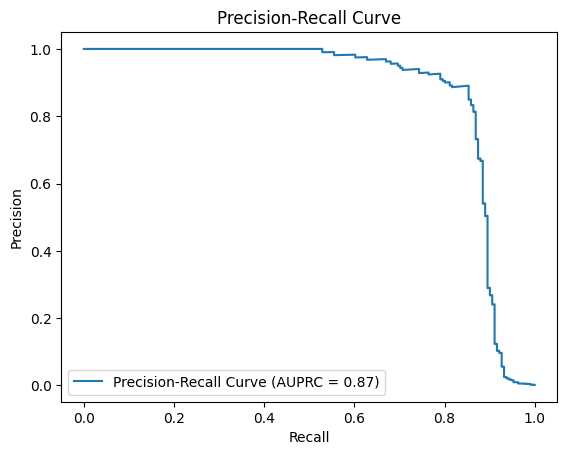

In [17]:
# Plot the Precision-Recall Curve
plt.plot(recall, precision, label='Precision-Recall Curve (AUPRC = %0.2f)' % auprc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

In [18]:

# Define the parameter grid for grid search
params  = {
    'learning_rate': [0.05, 0.10, 0.15, 0.20, 0.25, 0.3],
    'max_depth': [3,4,5,6,8,10,15] ,
    'min_child_weight': [0.0, 0.1, 0.2,0.3,0.4],
    'gamma': [0.0, 0.1, 0.2, 0.3, 0.4], 
    'colsample_bytree':[0.3, 0.4, 0.5, 0.7]
}


In [19]:
def auprc_score(y_true, y_proba):
    precision, recall, _ = precision_recall_curve(y_true, y_proba)
    return auc(recall, precision)
scorer = make_scorer(auprc_score, greater_is_better=True, needs_proba=True)


In [20]:
randomsearch = RandomizedSearchCV(model, param_distributions= params, n_iter = 5 , 
                                 scoring = scorer, n_jobs =1 , verbose = 3)

In [21]:
randomsearch.fit(X_sampled, y_sampled)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END colsample_bytree=0.3, gamma=0.4, learning_rate=0.1, max_depth=5, min_child_weight=0.4;, score=0.998 total time=   4.7s
[CV 2/5] END colsample_bytree=0.3, gamma=0.4, learning_rate=0.1, max_depth=5, min_child_weight=0.4;, score=0.998 total time=   5.4s
[CV 3/5] END colsample_bytree=0.3, gamma=0.4, learning_rate=0.1, max_depth=5, min_child_weight=0.4;, score=0.999 total time=   6.2s
[CV 4/5] END colsample_bytree=0.3, gamma=0.4, learning_rate=0.1, max_depth=5, min_child_weight=0.4;, score=0.998 total time=   6.8s
[CV 5/5] END colsample_bytree=0.3, gamma=0.4, learning_rate=0.1, max_depth=5, min_child_weight=0.4;, score=0.999 total time=   7.9s
[CV 1/5] END colsample_bytree=0.5, gamma=0.2, learning_rate=0.2, max_depth=15, min_child_weight=0.4;, score=0.999 total time=  17.6s
[CV 2/5] END colsample_bytree=0.5, gamma=0.2, learning_rate=0.2, max_depth=15, min_child_weight=0.4;, score=1.000 total time=  17.5s
[CV 3/5] END c

RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None...
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           predictor=None, random_state=None, ...),
                   n_iter=5, n_jobs=1,
                   param_distributions={'colsample_bytree': [0.3, 0.4, 0.5,
                                                             0.7],
                                        'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
                                        'learning_rate': [0.05, 0.1, 0.15, 0.2,
                                                          0.25, 0.3],
                                        'max_depth': [3, 4, 5, 6, 8, 10, 15],
                                        'min_child_weight': [0.0, 0.1, 0.2, 0.3,
                                                             0.4]},
                   scoring=make_scorer(auprc_score, needs_proba=True),
                   verbose=3)

In [22]:
randomsearch.best_params_

{'min_child_weight': 0.4,
 'max_depth': 15,
 'learning_rate': 0.2,
 'gamma': 0.2,
 'colsample_bytree': 0.5}

In [23]:
best_params ={'min_child_weight': 0.4,
 'max_depth': 15,
 'learning_rate': 0.2,
 'gamma': 0.2,
 'colsample_bytree': 0.5}

In [24]:
model_best = xgb.XGBClassifier(**best_params)

In [25]:
model_best.fit(X_sampled, y_sampled)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.2, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=15, max_leaves=None,
              min_child_weight=0.4, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [26]:
y_pred_proba = model_best.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
auprc = auc(recall, precision)

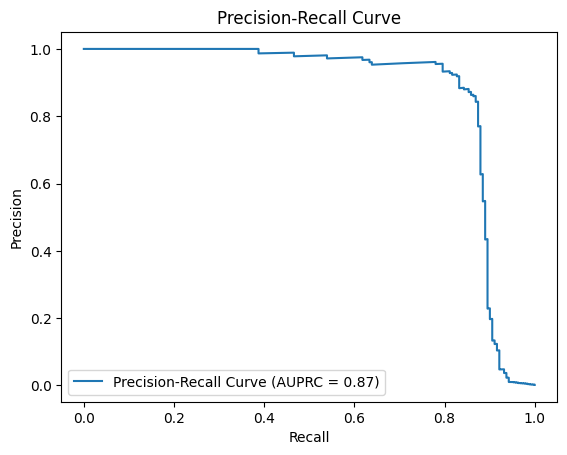

In [27]:
# Plot the Precision-Recall Curve
plt.plot(recall, precision, label='Precision-Recall Curve (AUPRC = %0.2f)' % auprc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

In [ ]:
# this is the max score achieved with the xGBoost 